In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn
import csv

import dataset
import datasplit
import model.models as models
import trainer
import utils
import pickle

In [2]:
# LOAD
# folders
models_folder = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/models'
model_name = '20201111_setnet_mono_disc_best'
results_folder = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/result'
results_subfolder = '20201111_setnet_mono_disc'

# Load the model
setnet = torch.load('%s/%s' % (models_folder, model_name), map_location=torch.device('cpu'), weights_only=False)

# Define paths for the result files
train_losses_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'all_train_losses')
train_correct_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'all_train_correct')
best_train_results_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'best_train_results')

val_losses_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'all_val_losses')
val_correct_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'all_val_correct')
best_val_results_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'best_val_results')

test_losses_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'all_test_losses')
test_correct_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'all_test_correct')
best_test_results_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'best_test_results')

fx_labels_path = '%s/%s/%s.pkl' % (results_folder, results_subfolder, 'fx_labels')

# Load the results using pickle
with open(train_losses_path, 'rb') as f:
    all_train_losses = pickle.load(f)

with open(train_correct_path, 'rb') as f:
    all_train_correct = pickle.load(f)

with open(best_train_results_path, 'rb') as f:
    best_train_results = pickle.load(f)

with open(val_losses_path, 'rb') as f:
    all_val_losses = pickle.load(f)

with open(val_correct_path, 'rb') as f:
    all_val_correct = pickle.load(f)

with open(best_val_results_path, 'rb') as f:
    best_val_results = pickle.load(f)

with open(test_losses_path, 'rb') as f:
    all_test_losses = pickle.load(f)

with open(test_correct_path, 'rb') as f:
    all_test_correct = pickle.load(f)

with open(best_test_results_path, 'rb') as f:
    best_test_results = pickle.load(f)

with open(fx_labels_path, 'rb') as f:
    fx_labels = pickle.load(f)

# Get datasets size
train_set_size = len(best_train_results)
val_set_size = len(best_val_results)
test_set_size = len(best_test_results)

# Example access
print(best_train_results[0])

(56345, 'G61-59404-MGS-D2T8-20636', array([1.   , 0.21 , 0.864], dtype=float32), array([1. , 0.2, 0.8], dtype=float32))


Best Train Accuracy:  59.093259589010295
Epoch:  49

Best Val Accuracy:  57.51138088012139
Epoch:  49

Test Accuracy:  58.613572902755855
Epoch:  49



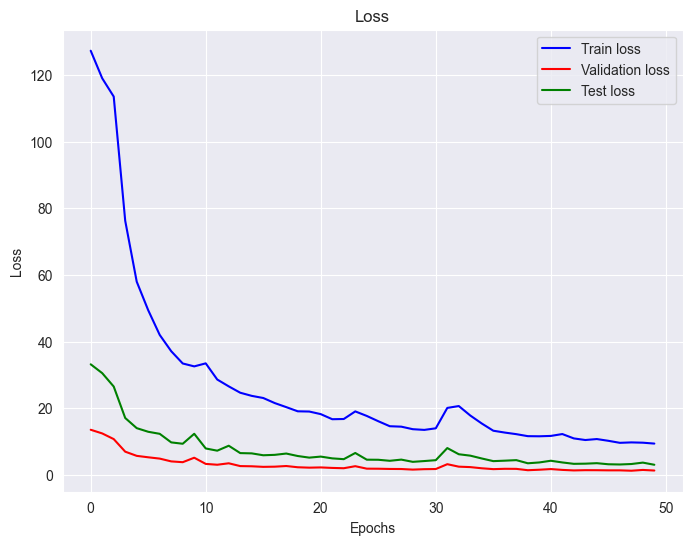

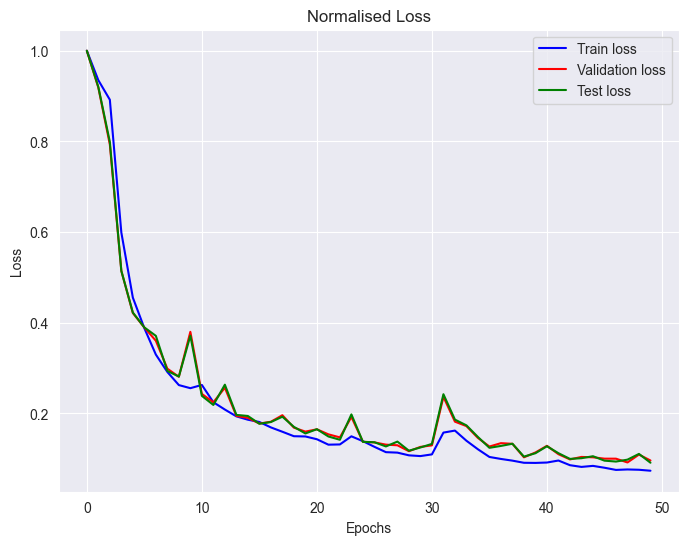

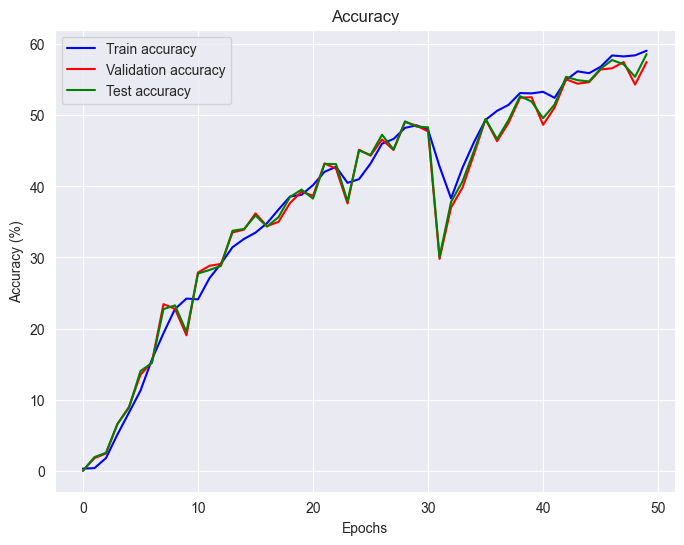

In [3]:
# Ustawienie ścieżki do zapisu
save_path = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/result/figures/SetNet_plots'

# BEST RESULTS
print('Best Train Accuracy: ', 100 * max(all_train_correct) / train_set_size)
print('Epoch: ', np.argmax(all_train_correct))
print()
print('Best Val Accuracy: ', 100 * max(all_val_correct) / val_set_size)
print('Epoch: ', np.argmax(all_val_correct))
print()
print('Test Accuracy: ', 100 * max(all_test_correct) / test_set_size)
print('Epoch: ', np.argmax(all_test_correct))
print()

# LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, all_train_losses, 'b', label='Train loss')
plt.plot(epochs, all_val_losses, 'r', label='Validation loss')
plt.plot(epochs, all_test_losses, 'g', label='Test loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{save_path}/loss_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

# NORMALISED LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, np.array(all_train_losses) / max(all_train_losses), 'b', label='Train loss')
plt.plot(epochs, np.array(all_val_losses) / max(all_val_losses), 'r', label='Validation loss')
plt.plot(epochs, np.array(all_test_losses) / max(all_test_losses), 'g', label='Test loss')
plt.title('Normalised Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{save_path}/normalised_loss_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

# ACCURACY
all_train_perc_correct = 100 * np.array(all_train_correct) / train_set_size
all_val_perc_correct = 100 * np.array(all_val_correct) / val_set_size
all_test_perc_correct = 100 * np.array(all_test_correct) / test_set_size
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, all_train_perc_correct, 'b', label='Train accuracy')
plt.plot(epochs, all_val_perc_correct, 'r', label='Validation accuracy')
plt.plot(epochs, all_test_perc_correct, 'g', label='Test accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f'{save_path}/accuracy_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

Best Validation Accuracy:  57.51138088012139 at epoch  49
Training Accuracy:  59.093259589010295
Test Accuracy:  58.613572902755855


G:\PracaMagisterska\Kod_na_magisterke\gfx-classifier_RNN_version\src\utils\utils.py:35: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


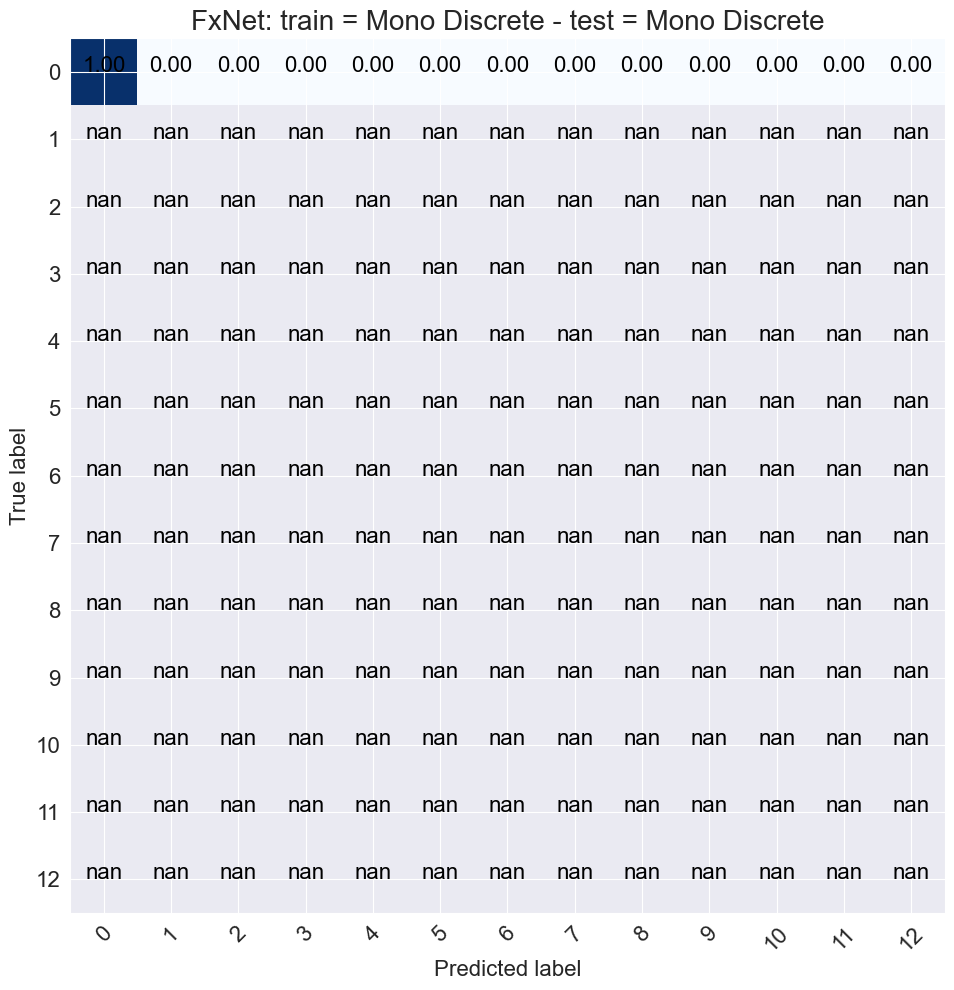

In [50]:

# Find best performance epoch based on validation
best_val = 100 * max(all_val_correct) / val_set_size
best_val_idx = np.argmax(all_val_correct)

print("Best Validation Accuracy: ", best_val, "at epoch ", best_val_idx)
print("Training Accuracy: ", 100 * all_train_correct[best_val_idx] / train_set_size)
print("Test Accuracy: ", 100 * all_test_correct[best_val_idx] / test_set_size)

# Extract predictions and targets vectors
train_preds = np.array([item[2] for item in best_train_results])
train_targets = np.array([item[3] for item in best_train_results])
val_preds = np.array([item[2] for item in best_val_results])
val_targets = np.array([item[3] for item in best_val_results])
test_preds = np.array([item[2] for item in best_test_results])
test_targets = np.array([item[3] for item in best_test_results])

# Convert predictions to discrete class labels if they are probabilities
train_preds_labels = np.argmax(train_preds, axis=1) if train_preds.ndim > 1 else train_preds
val_preds_labels = np.argmax(val_preds, axis=1) if val_preds.ndim > 1 else val_preds
test_preds_labels = np.argmax(test_preds, axis=1) if test_preds.ndim > 1 else test_preds

# Convert targets to single-label integers if they are one-hot encoded
train_targets = np.argmax(train_targets, axis=1) if train_targets.ndim > 1 else train_targets
val_targets = np.argmax(val_targets, axis=1) if val_targets.ndim > 1 else val_targets
test_targets = np.argmax(test_targets, axis=1) if test_targets.ndim > 1 else test_targets

# Calculate confusion matrices
labels = [str(i) for i in range(len(fx_labels))]  # Adjust according to the number of classes
train_cm = confusion_matrix(y_true=train_targets, y_pred=train_preds_labels, labels=range(len(fx_labels)))
val_cm = confusion_matrix(y_true=val_targets, y_pred=val_preds_labels, labels=range(len(fx_labels)))
test_cm = confusion_matrix(y_true=test_targets, y_pred=test_preds_labels, labels=range(len(fx_labels)))

# Plot confusion matrix for the test data
plt.figure(figsize=(10, 10))
utils.plot_confusion_matrix(test_cm, labels, normalize=True, title='FxNet: train = Mono Discrete - test = Mono Discrete', title_fontsize=20, text_fontsize=16)
# Uncomment the line below to save the figure if needed
# plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'fxnet_cm_MD_MD.eps'), format='eps')
plt.show()